# Gaussian process regression selecting best kernel through cross validation <br>
Reference : <br>
https://datachemeng.com/kernel_design_in_gpr/ <br>
https://upura.hatenablog.com/entry/2018/12/04/224436

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, WhiteKernel

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
X.head()

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
y.head()

,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
n_features = len(X.columns)
n_features

8

In [8]:
# dictionary of kernel
kernel_dict = {0:ConstantKernel() * DotProduct() + WhiteKernel(),
               1:ConstantKernel() * RBF() + WhiteKernel(),
               2:ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
               3:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel(),
               4:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel() + ConstantKernel() * DotProduct(),
               5:ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
               6:ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               7:ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
               8:ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               9:ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
               10:ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()}

### List of scores by KFold and Shaffle split

In [9]:
score_mean_KF = list()
score_mean_SS = list()

In [10]:
split_num = 5

C:\Users\mmm\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.96372818e-10, -1.70697107e-09,  7.22980088e+01,  2.83305391e+00,
        7.06927385e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 41, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


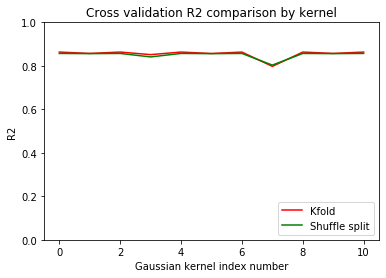

In [11]:
with np.errstate(invalid='ignore'):
    for i in kernel_dict.keys():
        kern = kernel_dict[i]
        cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
        score_temp_KF = list()
        
        for train_index, test_index in cv_KF.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
            gaussr = GaussianProcessRegressor(kernel=kern).fit(X_train, y_train)

            y_pred = gaussr.predict(X_test)
            R2_gauss = r2_score(y_test, y_pred)
            score_temp_KF.append(R2_gauss)
        score_mean_KF.append(np.mean(score_temp_KF))
        
    for j in kernel_dict.keys():
        kern = kernel_dict[j]
        cv_SS = ShuffleSplit(n_splits = split_num, random_state = 0, test_size=0.2, train_size=None)
        score_temp_SS = list()
        for train_index, test_index in cv_SS.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
            gaussr = GaussianProcessRegressor(kernel=kern).fit(X_train, y_train)

            y_pred = gaussr.predict(X_test)
            R2_gauss = r2_score(y_test, y_pred)
            score_temp_SS.append(R2_gauss)
        score_mean_SS.append(np.mean(score_temp_SS))

plt.plot(score_mean_KF, c = 'r', label = 'Kfold')
plt.plot(score_mean_SS, c = 'g', label = 'Shuffle split')
plt.title('Cross validation R2 comparison by kernel')
plt.xlabel('Gaussian kernel index number')
plt.ylabel('R2'), plt.ylim(0.0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

In [12]:
print('kernel index', 'KFold R2', 'ShuffleSplit R2', sep = '\t')
for i in kernel_dict.keys():
    print(i, '', ' {:.4}'.format(score_mean_KF[i]), '', ' {:.4}'.format(score_mean_SS[i]), sep = '\t')

kernel index	KFold R2	ShuffleSplit R2
0		 0.8634		 0.857
1		 0.8572		 0.8562
2		 0.8634		 0.857
3		 0.8516		 0.8411
4		 0.8634		 0.857
5		 0.8568		 0.8561
6		 0.8634		 0.857
7		 0.7976		 0.8034
8		 0.8634		 0.857
9		 0.8572		 0.8562
10		 0.8634		 0.857


### Best model selection

In [13]:
best_kernel_index = score_mean_SS.index(np.max(score_mean_SS))
print('Best kernel index (highest R2) = ', best_kernel_index)

Best kernel index (highest R2) =  8


In [14]:
best_gaussr = GaussianProcessRegressor(kernel = kernel_dict[best_kernel_index]).fit(X, y)

C:\Users\mmm\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:1372: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


In [15]:
# Save the best model
import pickle
with open('best_gaussr_sklearn.pickle', mode='wb') as f:
    pickle.dump(best_gaussr, f)

### Recall the model and check the fit

In [16]:
with open('best_gaussr_sklearn.pickle', mode='rb') as f:
    best_gaussr_recall = pickle.load(f)

In [17]:
y_pred = best_gaussr_recall.predict(X).reshape(-1, 1)
y_pred[:5]

array([[1.52008162],
       [1.51660894],
       [1.51590396],
       [1.51744385],
       [1.51671677]])

R2 =   0.8933


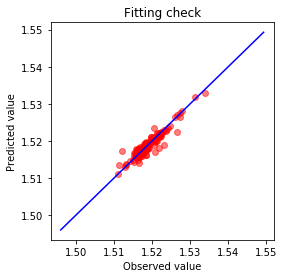

In [18]:
# For all
print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [19]:
# By validation set
print('Check best model perfromance in folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = best_gaussr_recall.predict(X_test)
    R2_gauss = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_gauss))

Check best model perfromance in folds
 0.9535
 0.9102
 0.784
 0.8594
 0.8904
